# **Breast Cancer - Comparative Analysis (Explainability with GradCAM) - EfficientNetV2L**

Dataset (Train and Validation) link: https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/

Annotated Dataset (Test) link: https://figshare.com/articles/dataset/BreCaHAD_A_Dataset_for_Breast_Cancer_Histopathological_Annotation_and_Diagnosis/7379186?file=13646369

The following project will focus on finding the architecture (used with GradCAM) with the best explainability efficiency. The proposed architectures for this experiment are:
* RegNetY
* EfficientNetV2L
* DenseNet
* NasNet

This notebook represents one of the four which will run experiments with images where the Visual Magnification factor is 400x - EfficientNetV2L.   

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import random
from random import random, randint, seed
import pickle
import pathlib
import warnings
import platform

import cv2
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import load_model
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

In [2]:
print("Python- Versão: ", platform.python_version())
print("TensorFLow - Versão: ",tf.__version__)

# Checar GPUs
if not tf.test.gpu_device_name():
    warnings.warn('GPU não encontrada.')
else:
    print(f'Dispositivo GPU padrão: {tf.test.gpu_device_name()}')
    print("Número de GPUs Disponíveis: ", len(tf.config.list_physical_devices('GPU')))


Python- Versão:  3.8.13
TensorFLow - Versão:  2.9.0
Dispositivo GPU padrão: /device:GPU:0
Número de GPUs Disponíveis:  1


In [3]:
for dirpath, dirnames, filenames in os.walk('BreakHis400x_Balanceado/Dataset'):
    if len(filenames)!=0:
        print(f'Existem {len(filenames)} imagens em  {dirpath}.')


Existem 90 imagens em  BreakHis400x_Balanceado/Dataset\test_set\benign.
Existem 90 imagens em  BreakHis400x_Balanceado/Dataset\test_set\malignant.
Existem 1037 imagens em  BreakHis400x_Balanceado/Dataset\train_set\benign.
Existem 1037 imagens em  BreakHis400x_Balanceado/Dataset\train_set\malignant.
Existem 90 imagens em  BreakHis400x_Balanceado/Dataset\validation_set\benign.
Existem 90 imagens em  BreakHis400x_Balanceado/Dataset\validation_set\malignant.


In [4]:
train_dir = 'BreakHis400x_Balanceado/Dataset/train_set/'
val_dir = 'BreakHis400x_Balanceado/Dataset/validation_set/'
test_dir = 'BreakHis400x_Balanceado/Dataset/test_set/'

# Especificações para o treinamento da rede
IMG_SHAPE = (224, 224, 3)
BATCH_SIZE = 8
EPOCHS = 20

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=BATCH_SIZE,  
                                               target_size=(224, 224), 
                                               class_mode="binary")

val_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=BATCH_SIZE,  
                                               target_size=(224, 224), 
                                               class_mode="binary")

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=BATCH_SIZE,  
                                               target_size=(224, 224), 
                                               class_mode="binary")

Found 2074 images belonging to 2 classes.
Found 180 images belonging to 2 classes.
Found 180 images belonging to 2 classes.


In [6]:
 # include_top=False retira a camada do topo, ou seja, a camada densa do modelo original
basemodel = EfficientNetV2L(include_top=False,
                                 weights='imagenet',
                                 input_shape=IMG_SHAPE,
                                 pooling='max')
# Note que a última camada de convolução termina com a operação de GlobalMaxPooling2D(dependendo do modelo poderia ser a Flatten
# ou GlobalAveragePooling)
# Assim, podemos adicionar a saída do baseModel diretamente na camada densa
#basemodel.summary()
print("Última camada do modelo base: ",basemodel.layers[-1])

Última camada do modelo base:  <keras.layers.pooling.global_max_pooling2d.GlobalMaxPooling2D object at 0x000001AE1AF49B20>


In [7]:
# Criar a arquitetura do modelo para o Fine Tuning
inputs = Input(shape=IMG_SHAPE)

x = basemodel(inputs)

x = Dense(512, activation="relu")(x)
x = Dropout(0.4)(x)

x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)

x = BatchNormalization()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)

x = BatchNormalization()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
'''
x = BatchNormalization()(x)
x = Dense(32, activation="relu")(x)
'''

outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs, outputs)


## Fine Tuning - Fase 1 (warm up) -> treina apenas a camada densa

In [8]:
# Congela as camadas do modelo base (as camadas de convolução não serão treinadas novamente)
for layer in basemodel.layers:
    layer.trainable = False  

In [9]:
base_learning_rate = 0.0001
opt = Adam(learning_rate=base_learning_rate)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [10]:
# Fase 1 - treina apenas com algumas épocas (50% do total)
initial_epochs = int(EPOCHS*0.5)
history = model.fit(train_data,
                    epochs=initial_epochs,
                    validation_data=val_data)

Epoch 1/10
260/260 [==============================] - 65s 170ms/step - loss: 0.8072 - accuracy: 0.5034 - val_loss: 0.6961 - val_accuracy: 0.5000
Epoch 2/10
260/260 [==============================] - 39s 149ms/step - loss: 0.7800 - accuracy: 0.5082 - val_loss: 0.7174 - val_accuracy: 0.5000
Epoch 3/10
260/260 [==============================] - 39s 151ms/step - loss: 0.7571 - accuracy: 0.5246 - val_loss: 0.6997 - val_accuracy: 0.5000
Epoch 4/10
260/260 [==============================] - 39s 151ms/step - loss: 0.7529 - accuracy: 0.5241 - val_loss: 0.7156 - val_accuracy: 0.5000
Epoch 5/10
260/260 [==============================] - 39s 151ms/step - loss: 0.7702 - accuracy: 0.4995 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 6/10
260/260 [==============================] - 39s 151ms/step - loss: 0.7665 - accuracy: 0.4976 - val_loss: 0.7044 - val_accuracy: 0.5000
Epoch 7/10
260/260 [==============================] - 39s 152ms/step - loss: 0.7466 - accuracy: 0.5135 - val_loss: 0.7188 - val_ac

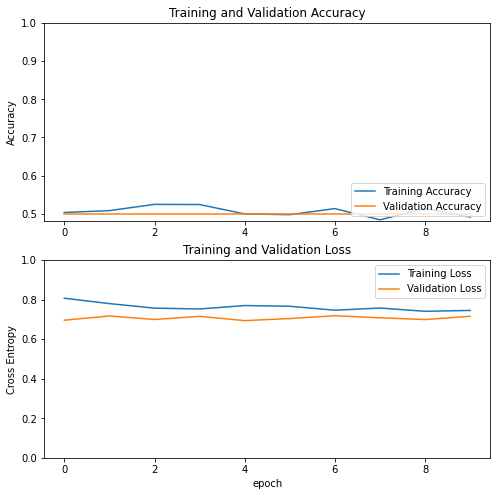

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning - Fase 2 -> treina todo o modelo do fine tuning - descongela as camadas de convolução

In [12]:
print("Número de camadas do modelo base: ", len(basemodel.layers))

Número de camadas do modelo base:  1029


In [13]:
# Descongelar as 20% camadas finais e que não seja do tipo BatchNormalization do modelo base
# Note que vpcê pode adicionar mais camadas se o modelo não for muito grande
count = 0
for layer in basemodel.layers[-int(len(basemodel.layers)*0.2):]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

In [14]:
# É necessário diminuir a base_learning_rate para que o modelo não tenha convergência muito rápida
# pois se trata d eum modelo grande
opt = Adam(learning_rate=base_learning_rate/10)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [15]:
# Fase 2 - treina apenas com a quantidade de épocas que faltam (50% finais)
# Note que iniciará de initial_epoch=history.epoch[-1]
history_fine = model.fit(train_data,
                    epochs=EPOCHS,
                    initial_epoch=history.epoch[-1],
                    validation_data=val_data)

Epoch 10/20
260/260 [==============================] - 76s 227ms/step - loss: 0.7425 - accuracy: 0.5068 - val_loss: 0.6953 - val_accuracy: 0.4556
Epoch 11/20
260/260 [==============================] - 55s 211ms/step - loss: 0.7334 - accuracy: 0.5101 - val_loss: 0.6968 - val_accuracy: 0.5056
Epoch 12/20
260/260 [==============================] - 56s 215ms/step - loss: 0.7337 - accuracy: 0.5106 - val_loss: 0.7277 - val_accuracy: 0.5000
Epoch 13/20
260/260 [==============================] - 56s 215ms/step - loss: 0.7407 - accuracy: 0.5043 - val_loss: 0.6968 - val_accuracy: 0.4778
Epoch 14/20
260/260 [==============================] - 56s 215ms/step - loss: 0.7447 - accuracy: 0.4860 - val_loss: 0.7200 - val_accuracy: 0.5000
Epoch 15/20
260/260 [==============================] - 56s 215ms/step - loss: 0.7477 - accuracy: 0.4957 - val_loss: 0.7235 - val_accuracy: 0.5000
Epoch 16/20
260/260 [==============================] - 56s 215ms/step - loss: 0.7427 - accuracy: 0.5068 - val_loss: 0.6936 -

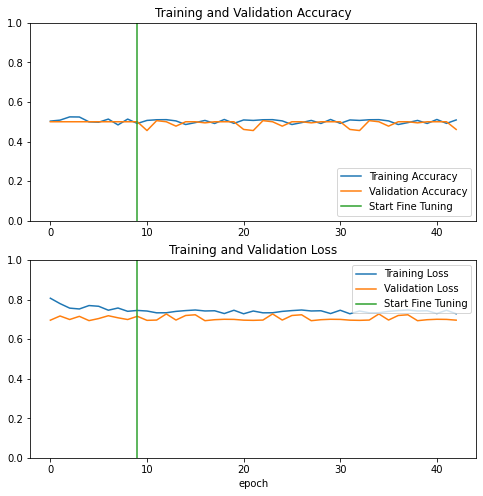

In [20]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [17]:
# Avaliação usando os dados de testes
model.evaluate(test_data)

23/23 [==============================] - 3s 127ms/step - loss: 0.6925 - accuracy: 0.5389


[0.6925098896026611, 0.5388888716697693]

In [18]:
model.save("Save_Model_EfficienteNetV2L")

INFO:tensorflow:Assets written to: Save_Model_EfficienteNetV2L\assets


INFO:tensorflow:Assets written to: Save_Model_EfficienteNetV2L\assets
